In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
import scipy.special as ss
import sys

In [2]:
def gen_data(n_pix, n_pulse, t_inter_p, lifetimes, spec_ind, exc_probs, tau_irf, sig_irf, bg):
    '''
    genData() generates a set of arrival times from input lifetimes
    and excitation probability.

    Args:
        npix (int): Number of pixels.
        npulse (int): Number of pulses per pixel.
        t_inter_p (float): Interpulse time (ns).
        lifetimes (array-like): Array of species lifetimes (ns).
        spec_ind (array-like): Index to assign spectrum from the list to species.
        exc_probs (array-like): Species excitation probabilities.
        tau_irf (float): Mean of the instrument response function (IRF) (ns).
        sig_irf (float): Standard deviation of the IRF (ns).
        bg (float): Background parameter for Poisson noise.

    Returns:
        tuple: A tuple containing the following:
            dt (list): Simulated arrival times per pixel.
            lambda_ (ndarray): Number of simulated photons per spectral band per pixel.
            spec_inten (ndarray): Number of simulated photons per spectral band per pixel per species.
    '''
    alphas = np.array([420, 55, 150, 200])
    betas = np.array([1.6, 10, 3.25, 2.9])
    spec_bands = np.linspace(375, 760, 32)
    n_spec = lifetimes.size

    n_channel = spec_bands.size
    lambda_ = np.zeros((n_pix, n_channel))
    nn = spec_ind.size
    spec_inten = np.zeros((n_pix, nn, n_channel))
    dt = []

    total_exc_prob = np.sum(exc_probs, axis=0)
    exc_probs = (exc_probs / total_exc_prob).T
    for pp in range(n_pix):


        pulse_excitation = 1 - np.exp(-2 * sig_irf * total_exc_prob[pp])
        pulse_excitation = pulse_excitation > np.random.rand(n_pulse)

        exc_pulse_indices = np.where(pulse_excitation)[0]
        exc_species_indices = np.random.choice(n_spec, size=len(exc_pulse_indices), p=exc_probs[pp])
        exc_species_lifetimes = lifetimes[exc_species_indices]

        exc_times = np.random.normal(tau_irf, sig_irf, len(exc_pulse_indices)) + np.random.exponential(exc_species_lifetimes)
        arrival_times = exc_times - t_inter_p * np.floor(exc_times / t_inter_p)

        tmp_lamds = np.random.gamma(alphas[exc_species_indices], betas[exc_species_indices])
        tmp_id = np.digitize(tmp_lamds, spec_bands) - 1
        tmp_id = np.clip(tmp_id, 0, 31)

        lambda_[pp] += np.bincount(tmp_id, minlength=32)

        # unique_species_indices, unique_counts = np.unique(exc_species_indices, return_counts=True)
        # spec_inten[pp, unique_species_indices, tmp_id] += unique_counts
        dt.append(arrival_times)
        # spec_inten[pp] /= np.sum(spec_inten[pp], axis=1, keepdims=True)

    return dt, lambda_, spec_inten

In [3]:
NPix = 44
NPulse = 10**5
#print(NPulse)
TInterP = 12.8
#print(TInterP)
Lifetimes = np.array([0.5, 1.5, 4, 7])
SpecInd = np.array([1, 2, 3, 4])
#print(Lifetimes)
ExcProbs = np.array([[0.008, 0., 0., 0.], [0.009, 0.006, 0., 0.], [0.006, 0., 0.009, 0.], [0.008, 0., 0, 0.008],
                     [0.006, 0.008, 0.007, 0.], [0.008, 0.006, 0.0, 0.007], [0.009, 0., 0.007, 0.006], [0.007, 0., 0., 0.006],
                     [0.007, 0.008, 0., 0.], [0.008, 0., 0.006, 0.], [0.007, 0.004, 0.008, 0.006], [0., 0.009, 0.0, 0.],
                     [0., 0.009, 0.007, 0.], [0., 0.007, 0.0, 0.009], [0., 0.006, 0.007, 0.004], [0, 0, 0., 0.008],
                     [0, 0, 0.008, 0.], [0, 0, 0.008, 0.006], [0, 0, 0.006, 0.], [0, 0, 0.006, 0.008],
                     [0.006, 0., 0., 0.], [0.005, 0.005, 0., 0.], [0.005, 0., 0.006, 0.], [0.005, 0., 0, 0.004],
                     [0.005, 0.004, 0.006, 0.], [0.005, 0.005, 0.0, 0.004], [0.005, 0., 0.005, 0.006], [0.003, 0., 0., 0.006],
                     [0.007, 0.008, 0., 0.], [0.008, 0., 0.006, 0.], [0.007, 0.004, 0.008, 0.003], [0., 0.004, 0.0, 0.],
                     [0., 0.004, 0.007, 0.], [0., 0.007, 0.0, 0.005], [0., 0.005, 0.007, 0.003], [0, 0, 0., 0.004],
                     [0.008, 0., 0., 0.], [0., 0.009, 0.0, 0.], [0., 0., 0, 0.008], [0, 0, 0.006, 0.],
                     [0.005, 0., 0.005, 0.005], [0., 0.004, 0.006, 0.004], [0.004, 0., 0.006, 0.004], [0.002, 0.1, 0.004, 0.006]
                     ]).T
#print(ExcProbs)
TauIRF = 8
#print(TauIRF)
SigIRF = 0.5
#print(SigIRF)
bg = 10
Dt,Lambda,_ = gen_data(NPix, NPulse, TInterP, Lifetimes, SpecInd, ExcProbs, TauIRF, SigIRF, bg)


In [4]:
def calculate_lifetime_likelihood(photon_int, eta, tau_irf,  sig_irf,dt, t_inter_p, num, i):
    """
    Calculate the lifetime part of the likelihood.

    Args:
        photon_int (ndarray): Photon intensities per pixel per species.
        eta (ndarray): Lifetimes.
        tau_irf (float): Mean of the instrument response function (IRF) (ns).
        sig_irf (float): Standard deviation of the IRF (ns).
        dt (ndarray): Arrival times.
        t_inter_p (float): Interpulse time (ns).
        num (int):
        i (int): Pixel index .

    Returns:
        float: Lifetime part of the likelihood.

    """
    dti = np.array(dt[i])
    lf_cont = np.sum(
        photon_int[:, i, np.newaxis, np.newaxis] *
        (
            (eta[:, np.newaxis, np.newaxis] / 2) *
            np.exp(
                (eta[:, np.newaxis, np.newaxis] / 2) *
                (
                    2 * (
                        tau_irf - dti[np.newaxis, :, np.newaxis] - np.arange(num)[np.newaxis, np.newaxis, :] * t_inter_p
                    ) +
                    eta[:, np.newaxis, np.newaxis] * sig_irf**2
                )
            ) *
            ss.erfc(
                (tau_irf - dti[np.newaxis, :, np.newaxis] - np.arange(num)[np.newaxis, np.newaxis, :] * t_inter_p +
                 eta[:, np.newaxis, np.newaxis] * sig_irf**2) /
                (sig_irf * np.sqrt(2))
            )
        ),
        axis=(0, 2)
    )
    return np.sum(np.log(lf_cont))


In [5]:
def sample_photon_probability(lambd, pi_old, photon_int, n_pix, accept_pi):

    """
    Sample the probability of a photon from the species to be detected in the lth spectral band.

    Args:
        lambd (numpy.ndarray): representing the number of photons per spectral band.
        pi_old (numpy.ndarray): representing current photon probabilities.
        photon_int (numpy.ndarray): Array of shape (NSpecies, NPix) representing photon intensities per pixel per species.
        n_pix (int): Total number of pixels.
        accept_pi (float): Accumulated acceptance rate.

    Returns:
        tuple: Tuple containing the updated pi_old array and the updated accept_pi value.
    """

    n_species, n_channel = pi_old.shape
    alpha = np.ones(n_channel) / n_channel
    alpha_prop = 1000

    i_0 = np.sum(lambd, axis=1)
    pi_new = np.copy(pi_old)
    m = np.random.choice(n_species)

    pi_new[m, :] = np.random.gamma(alpha_prop, pi_old[m, :] / alpha_prop)
    pi_new[m] /= np.sum(pi_new[m])
    a_top = 0
    a_bottom = 0
    for ii in range(np.size(i_0)):
        for ll in range(n_channel):
            tmp_top = np.sum(photon_int[:, ii] * pi_new[:,ll])
            if tmp_top > 0.001:
                a_top += sc.poisson.logpmf(lambd[ii, ll], tmp_top)
            tmp_b = np.sum(photon_int[:, ii] * pi_old[:, ll])
            if tmp_b > 0.001:
                a_bottom += sc.poisson.logpmf(lambd[ii, ll], tmp_b)

    # Calculating priors and proposal distributions
    a_prop = 0
    a_prior = 0
    for mm in range(pi_old.shape[0]):
        a_prop += np.sum(sc.dirichlet.logpdf(pi_old[mm,:], pi_new[mm,:])) - np.sum(sc.dirichlet.logpdf(pi_new[mm,:], pi_old[mm,:]))
        a_prior += np.sum(sc.dirichlet.logpdf(pi_new[mm,:], alpha/n_channel)) - np.sum(sc.dirichlet.logpdf(pi_old[mm,:], alpha/n_channel))
    a = (a_top - a_bottom) + a_prop + a_prior
    if a > np.log(np.random.rand()):
        pi_old = pi_new
        accept_pi += 1

    return pi_old, accept_pi


In [6]:
def sample_int(lambd, pi, i_old, n_pix, eta, tau_irf,  sig_irf,dt, t_inter_p, num, accept_i):
    '''
    sampling the intensities per spectral band per species
    lambd: number of photons per spectral band
    i_old(numpy.ndarray): Array of shape (NSpecies, NPix) representing photon intensities per pixel per species.
    pi: photon ratios per pixel per species
    n_pix: total number of pixels
    '''
    n_species, n_channel = pi.shape
    alpha_prop = 1000
    alpha_i = 1
    beta_i = 2100
    i_new = i_old.copy()
    for ii in range(n_pix):
        a_top = 0
        a_bottom = 0
        i_new[:,ii] = np.random.gamma(alpha_prop, i_old[:,ii]/alpha_prop)
#         lf_top = calculate_lifetime_likelihood(i_new, eta, tau_irf,  sig_irf,dt, t_inter_p, num, ii)
#         lf_bot = calculate_lifetime_likelihood(i_old, eta, tau_irf,  sig_irf,dt, t_inter_p, num, ii)
        for ll in range(n_channel):
            tmp_top = np.sum(i_new[:, ii] * pi[:,ll])
            if tmp_top != 0:
                a_top += sc.poisson.logpmf(lambd[ii, ll], tmp_top)
            tmp_b = np.sum(i_old[:, ii] * pi[:, ll])
            if tmp_b != 0:
                a_bottom += sc.poisson.logpmf(lambd[ii, ll], tmp_b)

        a_prior = np.sum(sc.gamma.logpdf(i_new[:,ii], alpha_i, scale=beta_i)) - np.sum(sc.gamma.logpdf(i_old[:,ii], alpha_i, scale=beta_i))
        a_prop = np.sum(sc.gamma.logpdf(i_old[:,ii], alpha_prop, scale= (i_new[:,ii]/alpha_prop))) -np.sum(sc.gamma.logpdf(i_new[:,ii], alpha_prop, scale= (i_old[:,ii]/alpha_prop)))
        a = (a_top - a_bottom) + a_prop + a_prior# + (lf_top - lf_bot)

        if a > np.log(np.random.rand()):
            i_old[:, ii] = i_new[:, ii]
            accept_i += (1/n_pix)

    return i_old, accept_i

In [7]:
def sample_lifetime(lambd, photon_int, n_pix, eta_old, tau_irf,  sig_irf, dt, t_inter_p, num, accept_eta):
    '''
    sampling the lifetime of species
    Args:
        lambd: number of photons per spectral band
        photon_int(numpy.ndarray): Array of shape (NSpecies, NPix) representing photon intensities per pixel per species.
        n_pix: total number of pixels
        eta_old: current lifetime.
        tau_irf (float): Mean of the impulse response function (IRF) in nanoseconds.
        sig_irf (float): Standard deviation of the IRF in nanoseconds.
        dt: time aravals.
        t_interp (float): Interpulse time in nanoseconds.
        num:
        accept_eta: sampling acceptance rate
    Returns:
        tuple: Tuple containing the updated eta array and the updated accept_eta value.
    '''
    alpha_prop = 1000
    alpha_eta = 1
    beta_eta = 20
    num = 4
    eta_prop = np.random.gamma(alpha_prop, eta_old/alpha_prop)


    lik_ratio = 0
    for ii in range(n_pix):
        lf_top = calculate_lifetime_likelihood(photon_int, eta_prop, tau_irf,  sig_irf, dt, t_inter_p, num, ii)
        lf_bot = calculate_lifetime_likelihood(photon_int, eta_old, tau_irf,  sig_irf, dt, t_inter_p, num, ii)

        lik_ratio += (lf_top - lf_bot)

    a_prior = np.sum(sc.gamma.logpdf(eta_prop, alpha_eta, scale=beta_eta)) - np.sum(sc.gamma.logpdf(eta_old, alpha_eta, scale=beta_eta))
    a_prop = np.sum(sc.gamma.logpdf(eta_old, alpha_prop, scale= (eta_prop/alpha_prop))) -np.sum(sc.gamma.logpdf(eta_prop, alpha_prop, scale= (eta_old/alpha_prop)))

    acc_ratio = lik_ratio + a_prop + a_prior
    if acc_ratio > np.log(np.random.rand()):
        eta_old = eta_prop
        accept_eta += 1


    return eta_old, accept_eta

In [8]:
def run_sflim_sampler(dt, lambda_, t_interp, tau_irf, sig_irf, t_inter_p, n_iter, m):
    """
    Runs the Gibbs sampling procedure for spectral fluorescence lifetime imaging microscopy (SFLIM).

    Args:
        dt (array): Set of arrival times.
        lambda_ (array): Number of photons within a set of 32 spectral bands.
        t_interp (float): Interpulse time in nanoseconds.
        tau_irf (float): Mean of the impulse response function (IRF) in nanoseconds.
        sig_irf (float): Standard deviation of the IRF in nanoseconds.
        n_iter (int): Number of iterations (samples).
        m (int): Number of species.

    Returns:
        pi (array): Sampled values for the photon probability parameters.
        photon_int (array): Sampled values for the photon intensity parameters.
    """
    nsb = 32
    npix = np.shape(lambda_)[0]
    nmax = 3
    X = np.linspace(381,754,32)
    num = 4

    # Allocating the chains
    eta = np.zeros((n_iter, m))
    pi = np.random.rand(n_iter, m, nsb)
    photon_int = np.zeros((n_iter, m, npix))

    # Initializing the chains
    eta[0, :] = np.random.gamma(1, scale=20, size=m)#np.divide(1, np.array([0.5, 2, 5]))

    for mm in range(m):
        pi[0, mm, :] /= np.sum(pi[0, mm, :])

    for ii in range(npix):
        photon_int[0, 0:m, ii] = np.random.gamma(1,1500, size=M)


    # Sampling the parameters
    accept_i = 0
    accept_pi = 0
    accept_eta = 0
    for jj in range(1, n_iter):
        if jj // 4000 == jj / 4000:
            print('iteration:', jj)
            print('Pi acceptance ratio:', 100 * accept_pi / jj)
            print('I acceptance ratio:', 100 * accept_i / jj)
            print('Eta acceptance ratio:', 100 * accept_eta / jj)
            


        pi[jj, :, :], accept_pi = sample_photon_probability(lambda_, pi[jj - 1, :, :], photon_int[jj - 1, :, :], npix, accept_pi)
        photon_int[jj, :, :], accept_i = sample_int(lambda_, pi[jj, :, :], photon_int[jj - 1, :, :], npix, eta[jj-1,:], tau_irf,  sig_irf,dt, t_inter_p, num,accept_i)
        eta[jj, :], accept_eta = sample_lifetime(lambda_, photon_int[jj - 1, :, :], npix, eta[jj-1,:], tau_irf,  sig_irf, dt, t_inter_p, num, accept_eta)


    print('Pi acceptance ratio:', 100 * accept_pi / n_iter)
    print('I acceptance ratio:', 100 * accept_i / n_iter)
    print('Eta acceptance ratio:', 100 * accept_eta / n_iter)

    return pi, photon_int, eta


In [ ]:
M = np.size(Lifetimes)
NIter = 50000
pi, photon_int, eta = run_sflim_sampler(Dt, Lambda, TInterP, TauIRF, SigIRF, TInterP, NIter, M)

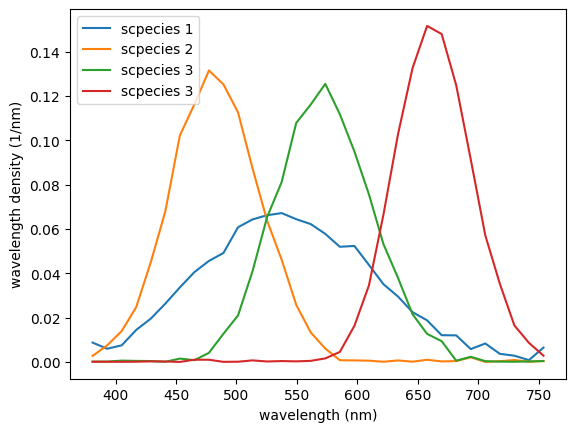

In [64]:
X = np.linspace(381,754,32)
plt.plot(X,np.mean(pi[-500:,0,:], axis=0), label='scpecies 1')
plt.plot(X,np.mean(pi[-500:,1,:], axis=0), label='scpecies 2')
plt.plot(X,np.mean(pi[-500:,2,:], axis=0), label='scpecies 3')
plt.plot(X,np.mean(pi[-500:,3,:], axis=0), label='scpecies 3')
plt.xlabel("wavelength (nm)")
plt.ylabel("wavelength density (1/nm)")
plt.legend()
# plt.savefig("reg_l.png")
plt.show()

In [65]:
1/np.array([0.5,1.5,4,7])

array([2.        , 0.66666667, 0.25      , 0.14285714])

In [40]:
np.mean(eta[:-500,:], axis=0)

array([0.14467714, 1.99242325, 0.45285362, 0.17131015])

In [66]:
oi = np.mean(photon_int[:-500,:], axis=0)
a = np.sum(Lambda, axis=1)
print("photon ratio with overlap:")
for j in range(np.size(a)):

    print(f"pixel {j}: learned-> {oi[:,j]/a[j]}, grand truth -> {ExcProbs[:,j]/np.sum(ExcProbs[:,j])}")

photon ratio with overlap:
pixel 0: learned-> [0.00880166 0.01572814 0.00848932 1.98463811], grand truth -> [1. 0. 0. 0.]
pixel 1: learned-> [0.6388165  0.1120918  0.0163363  1.23510322], grand truth -> [0.6 0.4 0.  0. ]
pixel 2: learned-> [0.06546105 1.18829988 0.02920027 0.72134634], grand truth -> [0.4 0.  0.6 0. ]
pixel 3: learned-> [0.00654278 0.01329717 1.04296598 0.94118232], grand truth -> [0.5 0.  0.  0.5]
pixel 4: learned-> [0.68377301 0.71397433 0.03685699 0.56651976], grand truth -> [0.28571429 0.38095238 0.33333333 0.        ]
pixel 5: learned-> [0.49629094 0.08086938 0.63556729 0.78836782], grand truth -> [0.38095238 0.28571429 0.         0.33333333]
pixel 6: learned-> [0.06383268 0.55872358 0.58021472 0.79891053], grand truth -> [0.40909091 0.         0.31818182 0.27272727]
pixel 7: learned-> [0.01620619 0.01201088 0.91293303 1.06673755], grand truth -> [0.53846154 0.         0.         0.46153846]
pixel 8: learned-> [0.94051245 0.12970403 0.02872032 0.91036571], grand t

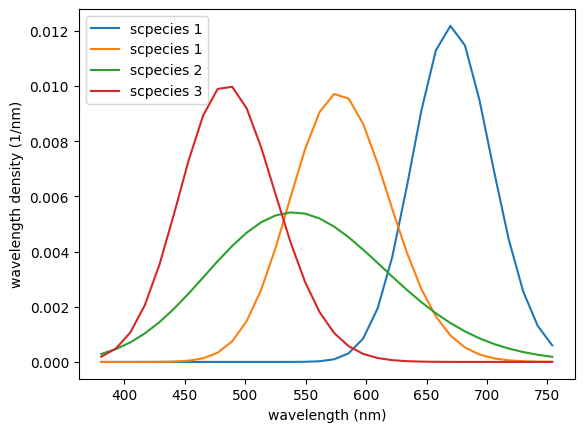

In [47]:
#alphas = np.array([1.4, 55, 420, 150, 200])
#betas = np.array([30, 10, 1.6, 3.25, 2.9])
# plt.figure(dpi=150)
plt.plot(X,sc.gamma.pdf(X,420,scale=1.6), label='scpecies 1')
plt.plot(X,sc.gamma.pdf(X,200,scale=2.9), label='scpecies 1')
plt.plot(X,sc.gamma.pdf(X,55,scale=10), label='scpecies 2')
plt.plot(X,sc.gamma.pdf(X,150,scale=3.25), label='scpecies 3')
plt.xlabel("wavelength (nm)")
plt.ylabel("wavelength density (1/nm)")
plt.legend()
plt.savefig("reg_gt.png")
plt.show()

In [ ]:
# photon_int[0, 0:m, 0] = np.array([1/3, 1/3, 1/3])*i_0[0]
# photon_int[0, 0:m, 1] = np.array([1/2, 0, 1/2])*i_0[1]
# photon_int[0, 0:m, 2] = np.array([0, 1/2, 1/2])*i_0[2]
# photon_int[0, 0:m, 3] = np.array([1/2, 1/2, 0])*i_0[3]
# photon_int[0, 0:m, 4] = np.array([0, 0, 1])*i_0[4]
# photon_int[0, 0:m, 5] = np.array([1/3, 1/3, 1/3])*i_0[5]
# photon_int[0, 0:m, 6] = np.array([1/2, 0, 1/2])*i_0[6]
# photon_int[0, 0:m, 7] = np.array([0, 1/2, 1/2])*i_0[7]
# photon_int[0, 0:m, 8] = np.array([1/2, 1/2, 0])*i_0[8]
# photon_int[0, 0:m, 9] = np.array([0, 0, 1])*i_0[9]
    # i_0 = np.sum(lambda_, axis=1)


    # Pre-calculating (Tau-Dt-nT)
    # dt_mod = {}
    # for nn in range(0, npix):
    #     tmp_dt_mod = tau_irf - dt[nn]
    #     dt_length = np.size(tmp_dt_mod)
    #     dt_mod[nn] = np.zeros((dt_length, nmax))
    #     for ii in range(0, nmax):
    #         dt_mod[nn][:, ii] = tmp_dt_mod - ii * t_interp
